In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import my_funcs as my

Debugging gpf (again)

In [348]:
def gpf(x0,p,num_iter=1000,eta1=0.1,eta2=0.1,history=False):
    x = x0.clone().detach()
    N = x.shape[0]
    D = x.shape[1]
    if history:
        x_history = torch.zeros((num_iter,N,D))
    for j in range(num_iter):
        
        x.requires_grad = True
        log_px = -p.log_prob(x) 
        log_px.sum().backward() #retain_graph = True
        g = x.grad.clone().detach()
        x.grad.data.zero_()
        
        g_ = g.mean(dim = 0)
        x_m = x - x.mean(dim = 0)
        #calculate Matrix A vectorised
        A = (1/N) * torch.mm(g.T,x_m) - torch.eye(D)
        #update particles
        x_new = x - eta1*g_.view(1,D) - eta2*torch.mm(x_m,A) 
        x = x_new.clone().detach()
        if history:
            x_history[j] = x_new.clone().detach()
    if history:
        return x_history
    else:
        return x

In [349]:
def gpf_T(x0,p,num_iter=1000,eta1=0.1,eta2=0.1,schedule = None,history=False):
    x = x0
    
    D = x.shape[0]
    N = x.shape[1]
    
    if history:
        x_history = torch.zeros((num_iter,D,N))
        
    for j in range(num_iter):
        
        x.requires_grad = True       
        log_p = torch.stack([-p.log_prob(x[:,i]) for i in range(N)])
        log_p.sum().backward()
        g = x.grad.clone().detach()    
        x.grad.data.zero_()
        
        g_ = g.mean(dim = 1)
        x_m = x - x.mean(dim = 1).view(D,1)
        A = (1/N) * torch.mm(g,x_m.T) - torch.eye(D)
        
        if type(schedule) != type(None):
            eta1 = schedule[j]
            eta2 = schedule[j]

        x_new = x - eta1*g_.view(D,1) - eta2*torch.mm(A,x_m) 
        x = x_new.clone().detach()
        
        if history:
            x_history[j] = x_new.clone().detach()

        
    if history:
        return x_history
    else:
        return x

In [162]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51] #number of particles to use
D = 50 #dimension of the target
num_runs = 1 #number of runs 
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0

In [300]:
C = Cs[-1]
N = Ns[1]
num_iter = 10000

target_mean = standard_normal.sample()
target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C,uniform=True)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
x0 = standard_normal.sample([N])


eta = 0.01

In [337]:
x = x0.T.clone().detach()
x.requires_grad = True
g = torch.zeros_like(x)
for i in range(N):
    log_px = -p.log_prob(x[:,i]) 
    log_px.sum().backward()
    g[:,i] = x.grad[:,i].clone().detach()
    x.grad.data.zero_()

print(g.shape)

torch.Size([50, 11])


In [336]:
x = x0.T.clone().detach()
x.requires_grad = True

log_p = torch.stack([p.log_prob(x[:,i]) for i in range(N)])
log_p.sum().backward()
g2 = x.grad.clone().detach()    
x.grad.data.zero_()

print(g2.shape)

torch.Size([50, 11])


In [343]:
t0 = time.time()
x = gpf_T(x0.T,p,num_iter = num_iter,eta1 = eta, eta2 = eta)
t1 = time.time()
print(t1-t0)

40.95826697349548


In [344]:
m,c,t = my.evaluate(x.T,p)

In [345]:
print(m)
print(c)
print(t)
print((ev_p[:N-1].sum() - ev_p.sum()).abs())

tensor(2.4228e-05)
tensor(0.1887)
tensor(42.5399)
tensor(42.5399)


In [350]:
t0 = time.time()
x_old = gpf(x0,p,num_iter = num_iter,eta1 = eta, eta2 = eta)
t1 = time.time()
print(t1-t0)

6.703762054443359


In [351]:
m,c,t = my.evaluate(x_old,p)
print(m)
print(c)
print(t)
print((ev_p[:N-1].sum() - ev_p.sum()).abs())

tensor(1.9396e-05)
tensor(0.4707)
tensor(103.9816)
tensor(42.5399)


In [398]:
N = 11
D = 50
eta = 0.01
num_iter = 10000

In [430]:
tic = time.time()
x = x0.clone().detach()
for j in range(num_iter):
    x.requires_grad = True
    
    log_px = -p.log_prob(x) 
    log_px.sum().backward()
    
    g = x.grad
    g_ = g.mean(dim = 0)
        
    x_m = x - x.mean(dim = 0)
    
    A = (1/N) * torch.mm(g.T,x_m) - torch.eye(D)
    x_new = x.T - eta*g_.view(D,1) - eta*torch.mm(A,x_m.T) 
    
    x = x_new.clone().detach().T
    
toc = time.time()
print(toc-tic)

6.769783020019531


In [431]:
m,c,t = my.evaluate(x,p)
print(m)
print(c)
print(t)
print((ev_p[:N-1].sum() - ev_p.sum()).abs())

tensor(2.3809e-05)
tensor(0.1887)
tensor(42.5399)
tensor(42.5399)


In [433]:
tic = time.time()
y = x0.T.clone().detach()
for j in range(num_iter):
    y.requires_grad = True 
    
    log_p = -p.log_prob(y.T).T
    log_p.sum().backward()
    s = y.grad.clone().detach()    
    y.grad.data.zero_()

    s_ = s.mean(dim = 1)
    y_m = y - y.mean(dim = 1).view(D,1)
    B = (1/N) * torch.mm(s,y_m.T) - torch.eye(D)
    y_new = y - eta*s_.view(D,1) - eta*torch.mm(B,y_m) 
    y = y_new.clone().detach()
toc = time.time()
print(toc-tic)

7.204926013946533


In [434]:
print(B.isclose(A).all())
print(A.isclose(B,atol = 1e-7).count_nonzero()/B.numel())


tensor(True)
tensor(1.)


In [391]:
print(log_p.T.isclose(log_px).all())
print(s.isclose(g).all())
print(s_.isclose(g_).all())
print(y_m.isclose(x_m).all())
print(B.isclose(A).all())
print(y.T.isclose(x).all())

tensor(True)
tensor(False)
tensor(True)
tensor(True)
tensor(False)
tensor(False)


In [393]:
print(s.isclose(g).count_nonzero()/g.numel())
print((s - g).abs().mean())

tensor(0.9836)
tensor(8.4890e-07)


In [394]:
A.diag().isclose(B.diag()).all()

tensor(True)

In [397]:
print(A.isclose(B,atol = 1e-7).count_nonzero()/B.numel())


tensor(0.9892)


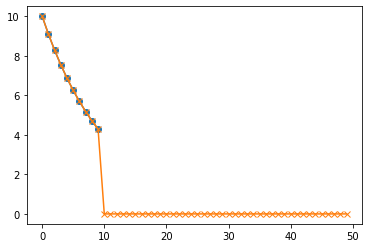

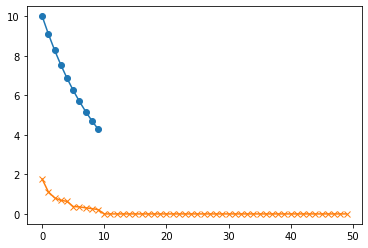

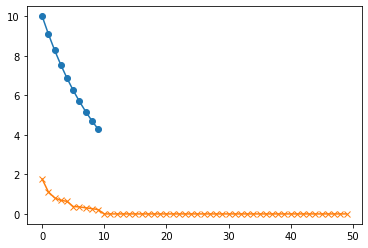

In [197]:
plt.plot(ev_p[:N-1],'o-')
plt.plot(ev_x_T,'x-')
plt.show()
plt.plot(ev_p[:N-1],'o-')
plt.plot(ev_x_old,'x-')
plt.show()
plt.plot(ev_p[:N-1],'o-')
plt.plot(ev_x,'x-')
plt.show()

Learning rate schedules

In [24]:
class SGD():
    
    def __init__(self, eta=0.01, gamma=-1,schedule = None):
        #eta -> default learning rate
        #gamma -> momentum term, if gamma < 0 no momentum is used
        #schedule -> learning rate schedule term
        #vel -> momentum based velocity term
        #iter -> tracks iterations for learning rate schedule
        
        self.__dict__.update(locals())
        self.vel = None
        self.iter = 0
        
    def __call__(self,x,g):
        
        
        
        if type(self.vel) == type(None): self.vel = torch.zeros_like(g)
            
        if type(self.schedule) != type(None): 
            self.eta = self.schedule[self.iter]
            self.iter += 1
            
        if 0 < self.gamma < 1: #if a valid momentum is given, use it 
            self.vel = self.vel * self.gamma + self.eta * g #calculate the velocity
            x_new = x - self.vel #update x with the velocity term
            
        else: #if no valid momentum is given
            x_new = x - self.eta * g #standard gradient descent update
            
        return x_new

In [59]:
C = Cs[-1]
N = Ns[-2]
num_iter = 30000

target_mean = standard_normal.sample()
target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
x0 = standard_normal.sample([N])

names = ['svgd','gpf']

eta = 5e-3
lrs = [5e-3,5e-3,5e-3,5e-3,1e-3,5e-4]

steps = int(num_iter/len(lrs))
assert len(lrs)*steps == num_iter, 'rly?'
step_schedule = torch.cat(([torch.full((steps,),e) for e in lrs]))

constant_schedule = torch.full(size=(num_iter,),fill_value = lrs[0])

schedules = [constant_schedule,step_schedule]
x = torch.empty((len(schedules),len(names),num_iter,N,D))
for i,schedule in enumerate(schedules):
    opti = SGD(eta = eta, schedule = schedule, gamma = -1)
    x[i,0] = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = opti, history = True)
    x[i,1] = gpf(x0,p,num_iter = num_iter,schedule = schedule, history = True)

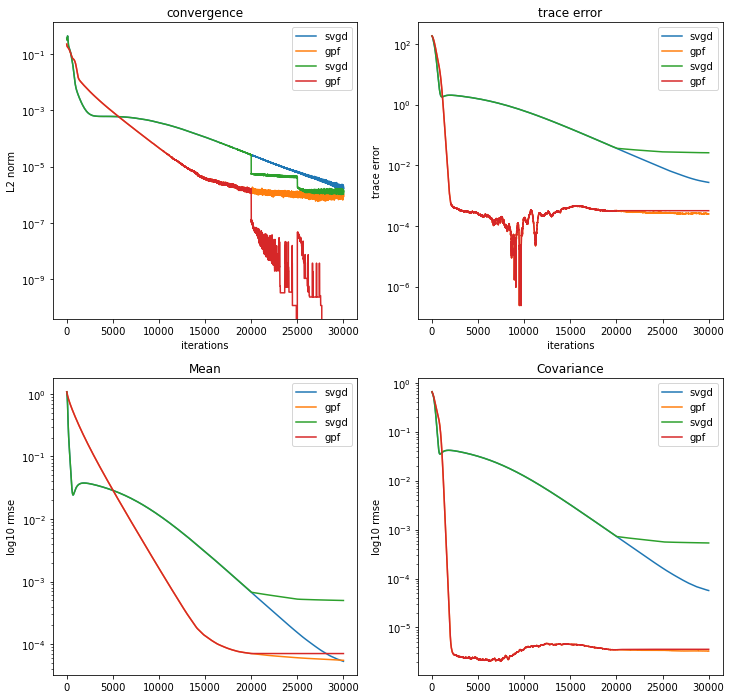

In [60]:
fig,axs = plt.subplots(2,2,figsize=(12,12))
for i,schedule in enumerate(schedules):
    for j,name in enumerate(names):
        cov = torch.stack([my.estimate_cov(z) for z in x[i,j]])
        l2step = torch.linalg.norm(x[i,j,1:]-x[i,j,:-1],dim=(1,2))
        mean_rmse = torch.sqrt(torch.mean((torch.mean(x[i,j],1)-p.mean)**2,1))
        cov_rmse = [torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov]
        trace_err = [torch.abs(torch.trace(c - p.covariance_matrix)) for c in cov]
        plt.sca(axs[0,0])
        plt.semilogy(l2step,label=names[j])
        plt.legend()
        plt.xlabel('iterations')
        plt.ylabel('L2 norm')
        plt.title('convergence')
        plt.sca(axs[0,1])
        plt.semilogy(trace_err,label=names[j])
        plt.legend()
        plt.ylabel('trace error')
        plt.xlabel('iterations')
        plt.title('trace error')
        plt.sca(axs[1,0])
        plt.semilogy(mean_rmse,label=names[j])
        plt.ylabel('log10 rmse')
        plt.title('Mean')
        plt.legend()
        plt.sca(axs[1,1])
        plt.semilogy(cov_rmse,label=names[j])
        plt.ylabel('log10 rmse')
        plt.title('Covariance')
        plt.legend()
plt.show()

Testing different optimizers 

In [101]:
class Adam():
    
    def __init__(self,eta = 0.001, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
        self.__dict__.update(locals())
        self.v = None
        self.m = None
        self.t = 0
    
    def __call__(self,x,g):
        
        if type(self.v) == type(None): self.v = torch.zeros_like(g)
        if type(self.m) == type(None): self.m = torch.zeros_like(g)
            
        self.t += 1
        
        self.m = self.beta1*self.m + (1-self.beta1)*g
        mt = self.m / (1-self.beta1**self.t)
        
        self.v = self.beta2*self.v + (1-self.beta2)*g.square()
        vt = self.v / (1-self.beta2**self.t)
        
        return x - eta * mt / (vt.sqrt() + self.eps)
        
    

In [ ]:
class SGD():
    
    def __init__(self, eta=0.01, gamma=-1):
        #eta -> default learning rate
        #gamma -> momentum term, if gamma < 0 no momentum is used
        #vel -> momentum based velocity term
        
        self.__dict__.update(locals())
        self.vel = None
        
    def __call__(self,x,g):
        
        if type(self.vel) == type(None):
            self.vel = torch.zeros_like(g)
            
        if 0 < self.gamma < 1: #if a valid momentum is given 
            self.vel = self.vel * self.gamma + self.eta * g #calculate the velocity
            x_new = x - self.vel #update x with the velocity term
            
        else: #if no valid momentum is given
            x_new = x - self.eta * g #standard gradient descent update
            
        return x_new

In [4]:
class AdaGrad():
    
    def __init__(self,eta = 0.01,alpha = -1, epsilon = 1e-8):
        #eta -> default learning rate
        #alpha -> fraction of gradient to accumulate (RMSprop vs AdaGrad)
        #epsilon -> correction term to avoid division by zero
        self.__dict__.update(locals())
        self.acc = None
    
    def __call__(self,x,g):
        
        if type(self.acc) == type(None):
            self.acc = torch.zeros_like(g)
            
        #accumulate the gradient
        if 0 < self.alpha < 1:
            #RMSprop
            #self.acc = self.acc*self.alpha + (1-self.alpha)*g**2
            self.acc = self.acc.mul(self.alpha).addcmul(g,g,value=1-self.alpha)
        else:
            #AdaGrad
            #self.acc = self.acc + g**2
            self.acc += torch.square(g)
            
        #take the root of the accumulated gradient and add a small correction term
        RMS = self.acc.sqrt().add(self.epsilon)
        #update with adapted learning rate: x <- x-eta*(g/RMS)
        x_new = x.addcdiv(g,RMS,value = -self.eta)
        
        return x_new

In [26]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51] #number of particles to use
D = 50 #dimension of the target
num_iter = 30000 #number of iterations
num_runs = 1 #number of runs 
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0


In [27]:
optimizers = [my.SGD(eta = 1e-3),
              my.SGD(eta = 1e-3,gamma = 0.9),
              my.AdaGrad(eta = 1e-3,alpha = 0.9),
              my.AdaGrad(eta = 1e-3, alpha = 0.5)]
names = ['sgd','sgd+mom','rmsprop','rmsprop+wang']

In [28]:
C = Cs[-1]
N = Ns[-1]

target_mean = standard_normal.sample()
target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
x0 = standard_normal.sample([N])

runtime = torch.zeros((len(optimizers),))
x_lin = torch.zeros((len(optimizers),num_iter,N,D))

for i,opti in enumerate(optimizers):
    t1 = time.time()
    x_lin[i] = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = opti, history = True)
    t2 = time.time()
    runtime[i] = np.around(t2 - t1,2)
    

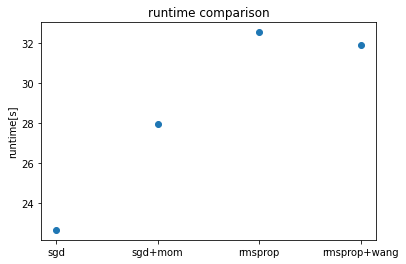

In [29]:
plt.plot(names,runtime,'o')
plt.title('runtime comparison')
plt.ylabel('runtime[s]')
plt.show()

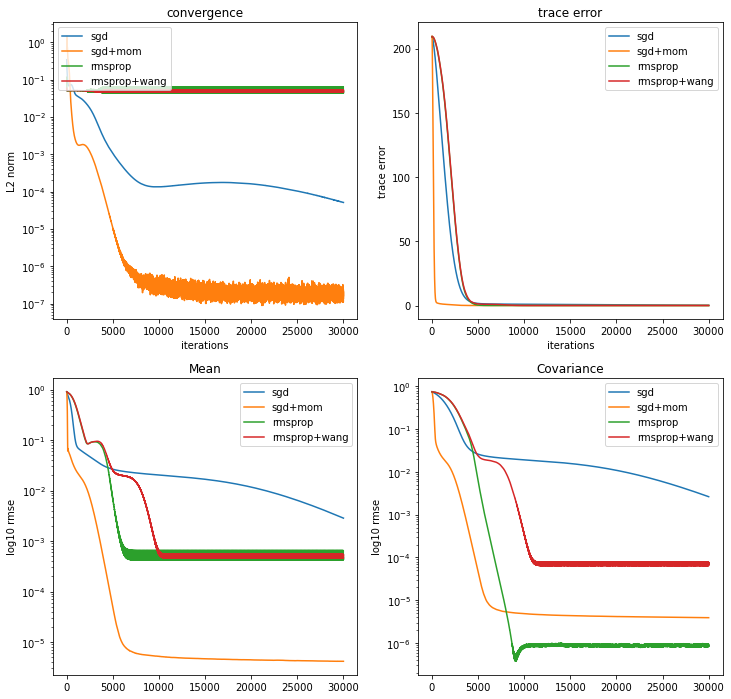

In [30]:
fig,axs = plt.subplots(2,2,figsize=(12,12))
for i,x in enumerate(x_lin):
    cov = torch.stack([my.estimate_cov(z) for z in x])
    l2step = torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
    mean_rmse = torch.sqrt(torch.mean((torch.mean(x,1)-p.mean)**2,1))
    cov_rmse = [torch.sqrt(torch.mean((c - p.covariance_matrix)**2)) for c in cov]
    trace_err = [torch.abs(torch.trace(c - p.covariance_matrix)) for c in cov]
    plt.sca(axs[0,0])
    plt.semilogy(l2step,label=names[i])
    plt.legend()
    plt.xlabel('iterations')
    plt.ylabel('L2 norm')
    plt.title('convergence')
    plt.sca(axs[0,1])
    plt.plot(trace_err,label=names[i])
    plt.legend()
    plt.ylabel('trace error')
    plt.xlabel('iterations')
    plt.title('trace error')
    plt.sca(axs[1,0])
    plt.semilogy(mean_rmse,label=names[i])
    plt.ylabel('log10 rmse')
    plt.title('Mean')
    plt.legend()
    plt.sca(axs[1,1])
    plt.semilogy(cov_rmse,label=names[i])
    plt.ylabel('log10 rmse')
    plt.title('Covariance')
    plt.legend()
plt.show()

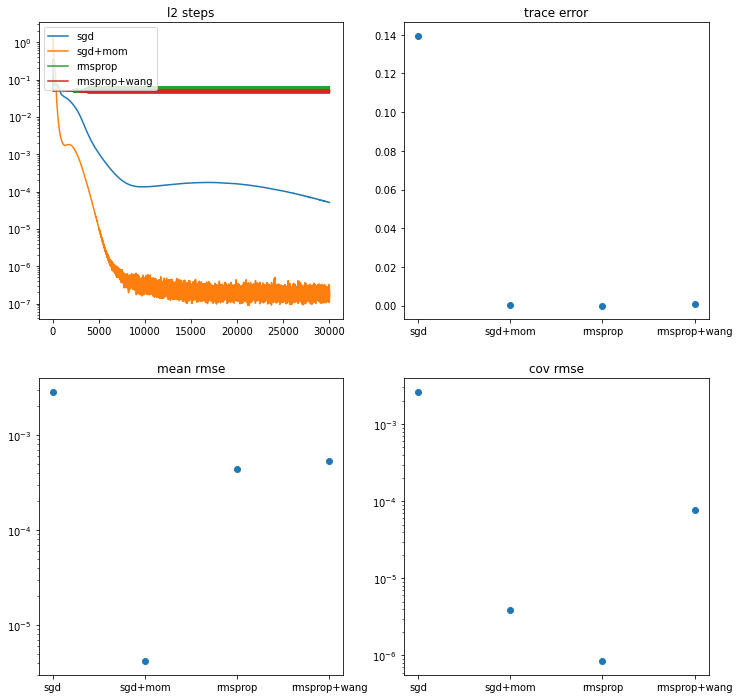

In [31]:
mean_rmse = torch.zeros((len(optimizers),))
cov_rmse = torch.zeros((len(optimizers),))
trace_err = torch.zeros((len(optimizers),))

fig,axs = plt.subplots(2,2,figsize=(12,12))
for i,x in enumerate(x_lin):
    c = my.estimate_cov(x[-1])
    l2step = torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
    mean_rmse[i] = torch.sqrt(torch.mean((torch.mean(x[-1],0)-p.mean)**2))
    cov_rmse[i] = torch.sqrt(torch.mean((c - p.covariance_matrix)**2))
    trace_err[i] = torch.abs(torch.trace(c - p.covariance_matrix))
    axs[0,0].semilogy(l2step,label=names[i])
    axs[0,0].legend()
axs[0,0].set_title('l2 steps')
axs[0,1].plot(names,trace_err,'o')
axs[0,1].set_title('trace error')
axs[1,0].semilogy(names,mean_rmse,'o')
axs[1,0].set_title('mean rmse')
axs[1,1].semilogy(names,cov_rmse,'o')
axs[1,1].set_title('cov rmse')
plt.show()

In [32]:
trace_err

tensor([1.3940e-01, 1.2827e-04, 2.9087e-05, 6.2633e-04])

In [2]:
Cs = [1,10,100] #condition numbers on the random covariance
Ns = [2,11,21,31,41,51] #number of particles to use
D = 50 #dimension of the target
num_iter = 20000 #number of iterations
num_runs = 10 #number of runs 
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0


In [3]:
N = Ns[-1]
C = Cs[-1]

Xs = torch.zeros((num_runs,2,N,D))
Ps = []
for run in range(num_runs):
    target_mean = standard_normal.sample()
    target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
    p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
    x0 = standard_normal.sample([N])
    
    optimizer = my.AdaGrad(eta = 10e-3,alpha = 0.9)
    Xs[run,0] = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer, history = False)
    
    optimizer2 = my.SGD(eta = 1e-3,gamma = 0.9)
    Xs[run,1] = my.svgd(x0,p,num_iter = num_iter,kernel = 'linear',optimizer = optimizer2, history = False)
    
    Ps.append(p)

In [ ]:
mean_rmse = [torch.sqrt(torch.mean(torch.square(
    torch.mean(Xs[i,0],0)-Ps[i].mean))) 
             for i in range(num_runs)]

cov_rmse = [torch.sqrt(torch.mean(torch.square(
    my.estimate_cov(Xs[i,0])-Ps[i].covariance_matrix))) 
            for i in range(num_runs)]

trace_err = [torch.abs(torch.trace(my.estimate_cov(Xs[i])-Ps[i].covariance_matrix)) for i in range(num_runs)]

In [4]:
mean_rmse = torch.zeros((num_runs,2))
cov_rmse = torch.zeros((num_runs,2))
trace_err = torch.zeros((num_runs,2))
for i in range(num_runs):
    for j in range(2):
        mean_rmse[i,j] = torch.sqrt(torch.mean(torch.square(torch.mean(Xs[i,j],0)-Ps[i].mean)))
        cov_rmse[i,j] = torch.sqrt(torch.mean(torch.square(my.estimate_cov(Xs[i,j])-Ps[i].covariance_matrix)))
        trace_err[i,j] = torch.abs(torch.trace(my.estimate_cov(Xs[i,j])-Ps[i].covariance_matrix))
                            

In [7]:
print('mean error RMSprop: 10e{:.2f} SGD: 10e{:.2f}'.format(torch.log10(torch.mean(mean_rmse[:,0])),
    torch.log10(torch.mean(mean_rmse[mean_rmse[:,1]==mean_rmse[:,1],1],0))))
print('cov error RMSprop: 10e{:.2f} SGD: 10e{:.2f}'.format(torch.log10(torch.mean(cov_rmse[:,0])),
    torch.log10(torch.mean(cov_rmse[cov_rmse[:,1]==cov_rmse[:,1],1],0))))
print('trace error RMSprop: 10e{:.2f} SGD: 10e{:.2f}'.format(torch.log10(torch.mean(trace_err[:,0])),
    torch.log10(torch.mean(trace_err[trace_err[:,1]==trace_err[:,1],1],0))))

mean error RMSprop: 10e-2.33 SGD: 10e-2.68
cov error RMSprop: 10e-3.34 SGD: 10e-2.63
trace error RMSprop: 10e-2.26 SGD: 10e-0.93


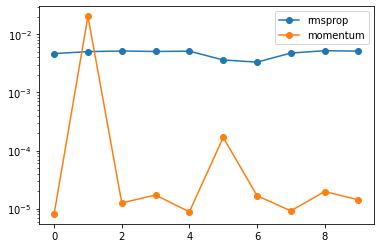

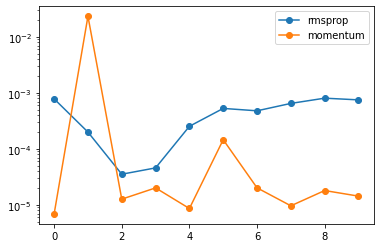

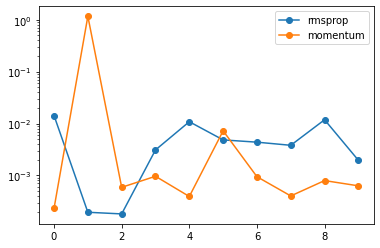

In [6]:
plt.semilogy(mean_rmse,'o-')
plt.legend(labels=['rmsprop','momentum'])
plt.show()
plt.semilogy(cov_rmse,'o-')
plt.legend(labels=['rmsprop','momentum'])
plt.show()
plt.semilogy(trace_err,'o-')
plt.legend(labels=['rmsprop','momentum'])
plt.show()

random covariance uniform

In [28]:
def random_covariance(D,Lmin=1,Lmax=1,uniform = False):
    #generate diagonal matrix with eigenvalues in the desired range (i.e. [1e-1,1e1])
    if uniform:
        L = torch.eye(D) * torch.pow(10,torch.log10(torch.div(Lmax,Lmin))*torch.linspace(0,D-1,D).div(D-1) -1)
    else:
        L = torch.eye(D) * (torch.rand([D])*(Lmax - Lmin) + Lmin)
    #generate a random unitary matrix (use QR decomposition to obtain)
    Q,_ = torch.qr(torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)).sample([D]))
    #obtain the desired covariance by multiplication:
    sigma = torch.mm(torch.mm(Q,L),Q.T)
    return sigma

In [29]:
Lmin = 0.1
Lmax = 10
D = 50

In [30]:
L1 = random_covariance(D,Lmin,Lmax, uniform = True)
L2 = random_covariance(D,Lmin,Lmax)

In [31]:
evs=random_covariance(D,Lmin,Lmax, uniform = True).svd(compute_uv=False)[1]
evs.max()/evs.min()

tensor(99.9999)

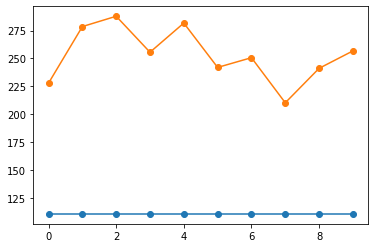

In [32]:
plt.plot([random_covariance(D,Lmin,Lmax, uniform = True).trace() for i in range(10)],'o-')
plt.plot([random_covariance(D,Lmin,Lmax).trace() for i in range(10)],'o-')

GPF testing

In [39]:
def gpf_debug(x0,p,num_iter=1000,eta1=0.1,eta2=0.1,history=False):
    x = x0.clone().detach()
    N = x.shape[0]
    D = x.shape[1]
    
    if history:
        x_history = torch.zeros((num_iter,N,D))
        
    for j in range(num_iter):
        #calculate score
        x.requires_grad = True
        log_px = -p.log_prob(x) 
        log_px.sum().backward(retain_graph = True)
        
        #compute g and g_
        g = x.grad.clone()
        g_ = g.mean(dim = 0)
        
        #zero x.grad for later use
        x.grad.data.zero_()
        
        #center the particles
        x_m = x - x.mean(dim = 0)
        
        #calculate Matrix A vectorised
        A = (1/N) * torch.mm(g.T,x_m) - torch.eye(D)
        
        #update particles
        x_new = x - eta1*g_.view(1,D) - eta2*torch.mm(x_m,A) 
        x = x_new.clone().detach()
        
        if history:
            x_history[j] = x_new.clone().detach()

        
    if history:
        return x_history
    else:
        return x

In [47]:
D = 50
C = 1
N = D+1
eta = 10e-3
num_iter = 10000

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0

target_mean = standard_normal.sample()
target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
x0 = standard_normal.sample([N])

In [ ]:
x = gpf_debug(x0,p,num_iter = num_iter, eta1 = eta, eta2 = eta)
m,c,t = my.estimate_cov(x,p)

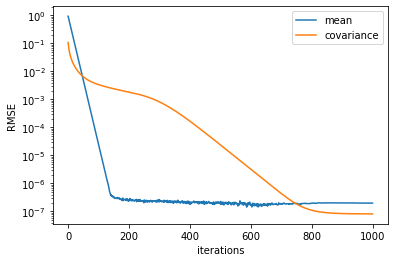

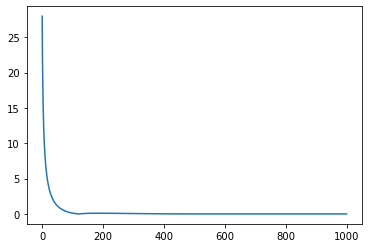

In [53]:
plt.semilogy(m,label='mean')
plt.semilogy(c,label='covariance')
plt.xlabel('iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()
plt.plot(t)
plt.show()

In [105]:
D = 50
standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)) #q0
eta = 10e-3
num_iter = 5000
Cs = [1,10,100]
Ns = [2,21,31,41,51,61]
names = ['svgd_momentum','svgd_rmsprop','svgd_adam']
m = torch.zeros((len(Cs),len(Ns),len(names)))
c = torch.zeros((len(Cs),len(Ns),len(names)))
t = torch.zeros((len(Cs),len(Ns),len(names)))
evs_x = torch.zeros((len(Cs),len(Ns),len(names),D))
evs_p = torch.zeros((len(Cs),D))
for i,C in enumerate(Cs):
    target_mean = standard_normal.sample()
    target_covariance = my.random_covariance(D,Lmin = 0.1, Lmax = 0.1*C,uniform=True)
    p = torch.distributions.MultivariateNormal(target_mean,target_covariance)
    _,evs_p[i],_ = p.covariance_matrix.svd(compute_uv=False)
    for j,N in enumerate(Ns):
        x0 = standard_normal.sample([N])
        for k,name in enumerate(names):
            if name == 'gpf':
                x = my.gpf(x0,p,num_iter = num_iter, eta1 = eta, eta2 = eta)
            elif name == 'svgd_rmsprop':
                optimizer = my.AdaGrad(eta = eta, alpha = 0.9)
                x = my.svgd(x0,p,num_iter = num_iter, kernel = 'linear',optimizer = optimizer)
            elif name == 'svgd_momentum':
                optimizer = my.SGD(eta = 1e-3, gamma = 0.9)
                x = my.svgd(x0,p,num_iter = num_iter, kernel = 'linear',optimizer = optimizer)
            elif name == 'svgd_adam':
                optimizer = Adam(eta = 10e-3)
                x = my.svgd(x0,p,num_iter = num_iter,optimizer = optimizer)
                
            m[i,j,k],c[i,j,k],t[i,j,k] = my.evaluate(x,p)
            _,evs_x[i,j,k],_ = my.estimate_cov(x).svd(compute_uv=False)

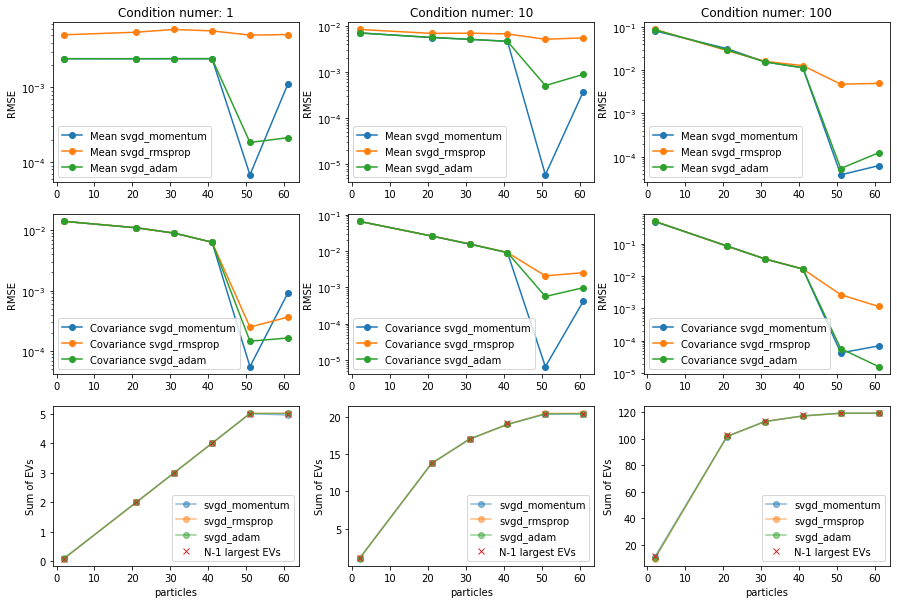

In [106]:
fig,axs = plt.subplots(3,len(Cs),figsize=(15,10))
for i,C in enumerate(Cs):
    for k,name in enumerate(names):
        plt.sca(axs[0,i])
        plt.semilogy(Ns,m[i,:,k],'o-',label='Mean {}'.format(name))
        plt.sca(axs[1,i])
        plt.semilogy(Ns,c[i,:,k],'o-',label='Covariance {}'.format(name))
        plt.sca(axs[2,i])
        plt.plot(Ns,evs_x[i,:,k].sum(dim=-1),'o-',alpha=0.5,label=name)
    
    plt.sca(axs[0,i])
    plt.legend()
    plt.title('Condition numer: {}'.format(C))
    plt.ylabel('RMSE')
    plt.sca(axs[1,i])
    plt.ylabel('RMSE')
    plt.legend()
    plt.sca(axs[2,i])
    n_evs = torch.stack([evs_p[i,:N-1].sum(dim=-1) for j,N in enumerate(Ns)])
    plt.plot(Ns,n_evs,'x',label='N-1 largest EVs')
    plt.xlabel('particles')
    plt.ylabel('Sum of EVs')
    plt.legend()

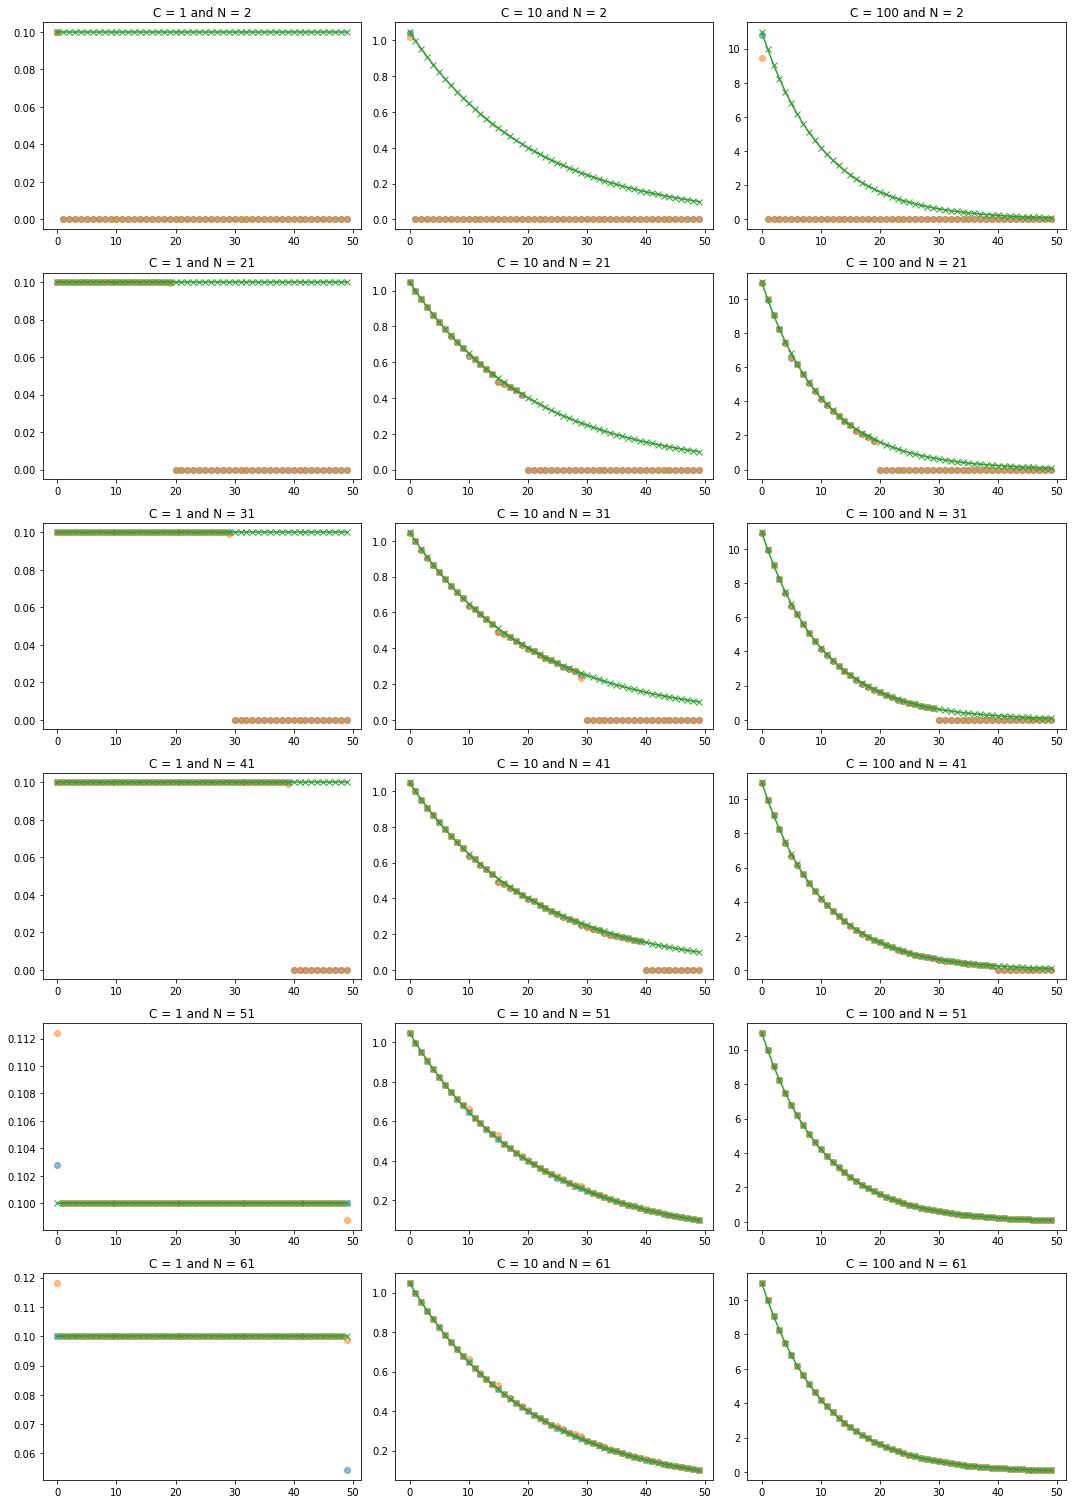

In [107]:
fig,axs = plt.subplots(len(Ns),len(Cs),figsize=(15,21))
for i in range(len(Cs)):
    for j in range(len(Ns)):
        plt.sca(axs[j,i])
        for k,name in enumerate(names[:2]):
            plt.plot(evs_x[i,j,k],'o',label=name,alpha=0.5)
        plt.plot(evs_p[i],'x-',label='Target')
        plt.title('C = {} and N = {}'.format(Cs[i],Ns[j]))
plt.tight_layout()
plt.show()


TypeError: log10(): argument 'input' (position 1) must be Tensor, not int

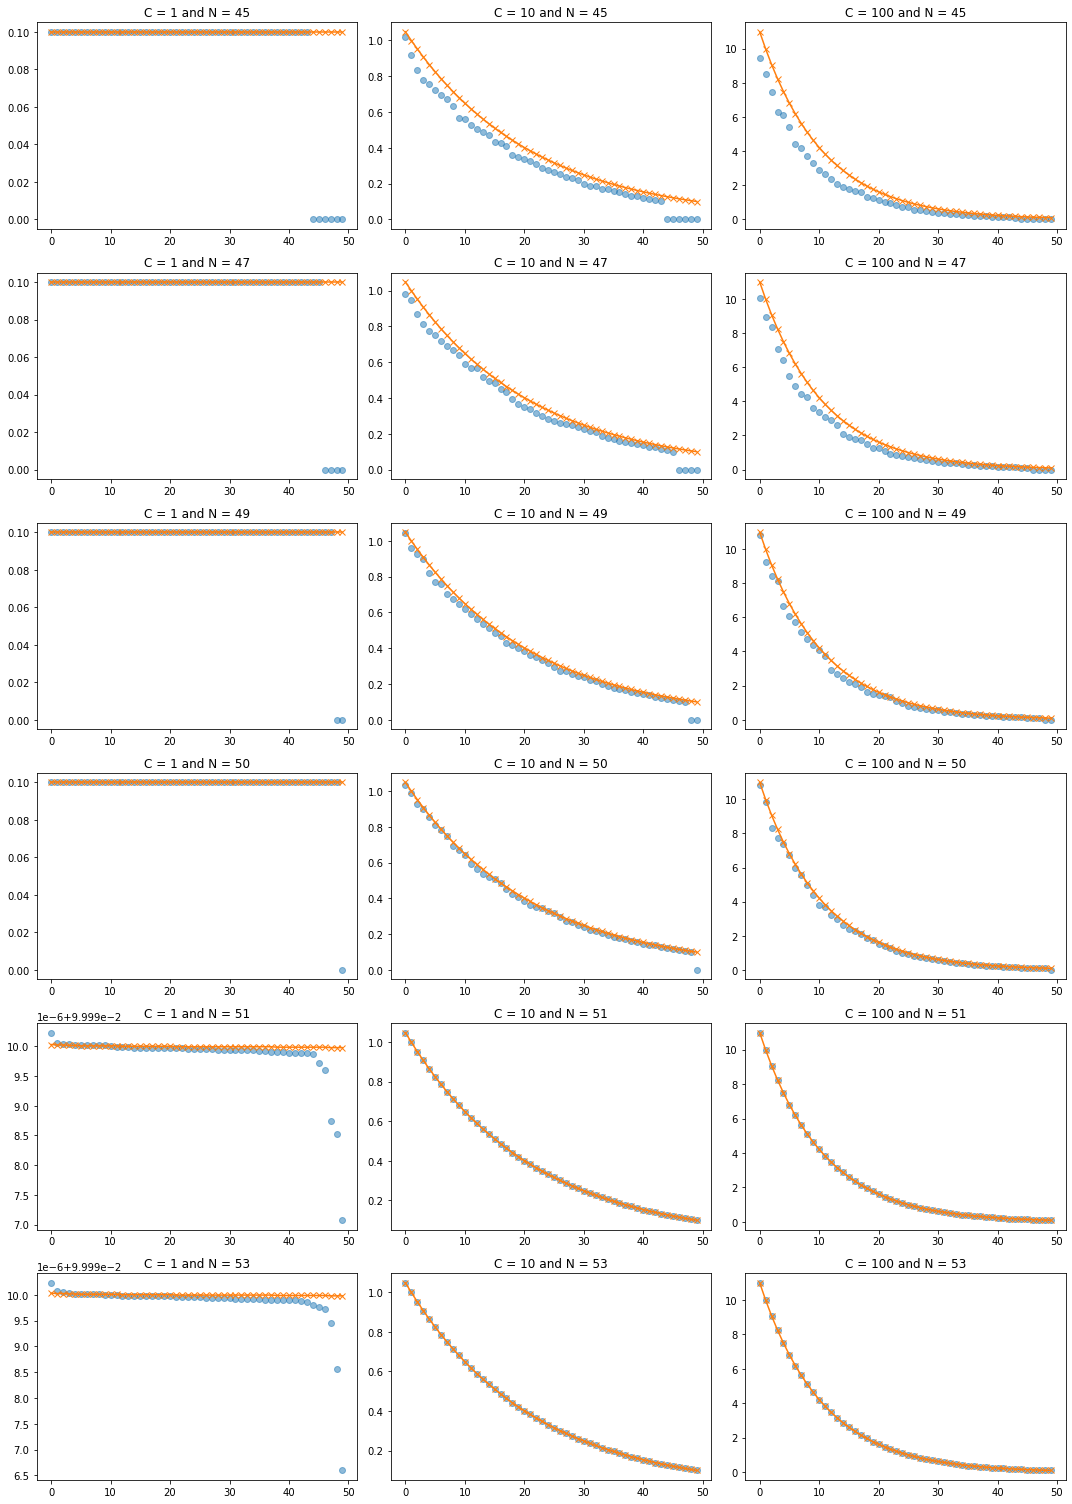

In [84]:
fig,axs = plt.subplots(len(Ns),len(Cs),figsize=(15,21))
for i in range(len(Cs)):
    for j in range(len(Ns)):
        plt.sca(axs[j,i])
        for k,name in enumerate(names[:2]):
            plt.plot(evs_x[i,j,k],'o',label=name,alpha=0.5)
        plt.plot(evs_p[i],'x-',label='Target')
        plt.title('C = {} and N = {}'.format(Cs[i],Ns[j]))
plt.tight_layout()
plt.show()


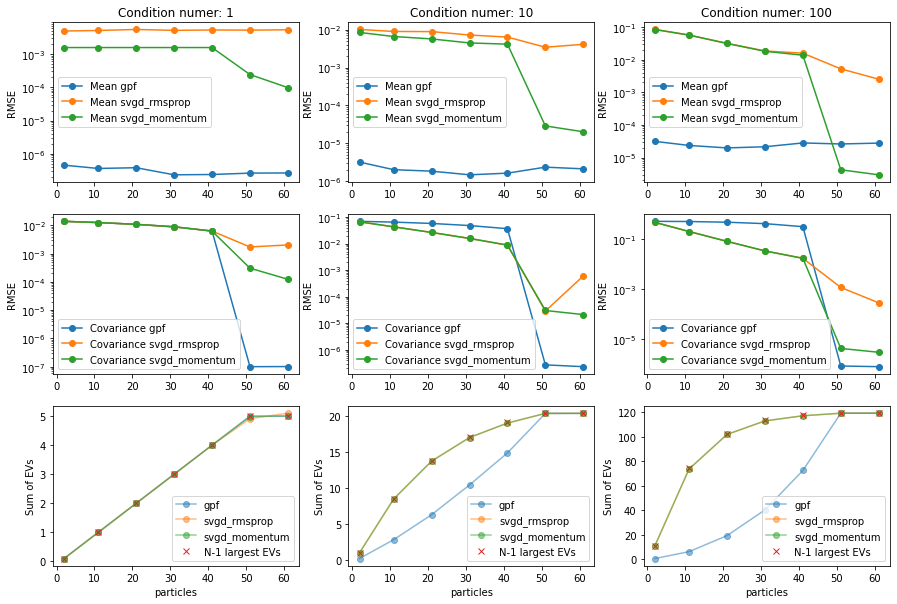

In [61]:
fig,axs = plt.subplots(3,len(Cs),figsize=(15,10))
for i,C in enumerate(Cs):
    for k,name in enumerate(names):
        plt.sca(axs[0,i])
        plt.semilogy(Ns,m[i,:,k],'o-',label='Mean {}'.format(name))
        plt.sca(axs[1,i])
        plt.semilogy(Ns,c[i,:,k],'o-',label='Covariance {}'.format(name))
        plt.sca(axs[2,i])
        plt.plot(Ns,evs_x[i,:,k].sum(dim=-1),'o-',alpha=0.5,label=name)
    
    plt.sca(axs[0,i])
    plt.legend()
    plt.title('Condition numer: {}'.format(C))
    plt.ylabel('RMSE')
    plt.sca(axs[1,i])
    plt.ylabel('RMSE')
    plt.legend()
    plt.sca(axs[2,i])
    n_evs = torch.stack([evs_p[i,:N-1].sum(dim=-1) for j,N in enumerate(Ns)])
    plt.plot(Ns,n_evs,'x',label='N-1 largest EVs')
    plt.xlabel('particles')
    plt.ylabel('Sum of EVs')
    plt.legend()

In [45]:
(my.estimate_cov(x[-1]) - p.covariance_matrix).trace().abs()

tensor(0.2000)

Stuff

In [26]:
def rbf_kernel(x,N,h=-1):
    #pairwise squared euclidean distances
    dist_mat = squared_distance(x)
    #if no proper bandwidth is given
    if h < 0:
        #use the heuristic from liu&wang2016
        h = torch.median(dist_mat)/torch.log(torch.FloatTensor([N+1]))
    #rbf kernel formula
    kxx = torch.exp(-dist_mat/h)
    #vectorized form of the derivative of the rbf kernel
    dxkxx = (-torch.mm(kxx,x)+kxx.sum(1).view(-1,1)*x)*(2/h)
    return kxx, dxkxx


def linear_kernel(x,N):
    #linear kernel is defined as x * x.T + c
    kxx = torch.mm(x,x.T)+torch.ones([N,N]) #do we add 1 to every matrix entry? or just to the diagonal?#+torch.eye(N)
    #vectorized derivative
    dkxx = (N+1) * x
    return kxx, dkxx

def svgd(x0,p,kernel = 'linear',num_iter = 10000, eta = 1e-3,history=False):
    x = x0.clone().detach()
    N = x.shape[0]
    D = x.shape[1]
    
    if history:
        x_history = torch.zeros((num_iter,N,D))
        
    for it in range(num_iter):
        #enable autograd for x
        x.requires_grad = True
        
        #calculate kernel and kernel_gradient
        if kernel == 'rbf':
            kxx,dkxx = rbf_kernel(x,N)
        elif kernel == 'linear':
            kxx,dkxx = linear_kernel(x,N)
        else:
            raise NotImplementedError('Please choose from linear or rbf kernel')
            
        #calculate the log-likelihood of x
        logpx = p.log_prob(x)
        #calculate the derivative of the log-likelihood wrt x
        logpx.sum().backward(retain_graph = True)
        dxlogpx = x.grad.clone().detach()
        #zero x.grad for later use (just in case)
        x.grad.data.zero_()    
        #calculate optimal perturbation direction
        phi = (1/N) *( torch.mm(kxx,dxlogpx) + dkxx)
        #make a step of gradient descent
        x_new = x + eta * phi
        
        if history:
            x_history[it] = x_new.clone().detach()
        x = x_new.clone().detach()
        
    if history:
        return x_history
    else:
        return x

def gpf(x0,p,num_iter=1000,eta1=0.1,eta2=0.1,history=False):
    x = x0.clone().detach()
    N = x.shape[0]
    D = x.shape[1]
    
    if history:
        x_history = torch.zeros((num_iter,N,D))
        
    for j in range(num_iter):
        #calculate score
        x.requires_grad = True
        log_px = -p.log_prob(x) 
        log_px.sum().backward(retain_graph = True)
        #compute g and g_
        g = x.grad
        g_ = torch.mean(g,0)
        #center the particles
        x_m = x - torch.mean(x,0)
        #calculate Matrix A particle-wise
        a = torch.zeros([D,D])
        for i in range(N):
            a += torch.mm(g[i].view(D,1),x_m[i].view(1,D))
        A = a/N - torch.eye(D)
        #update particles
        x_new = x - eta1*g_.view(1,D) - eta2*torch.mm(x_m,A) 
        x = x_new.clone().detach()
        
        if history:
            x_history[j] = x_new.clone().detach()
            
    if history:
        return x_history
    else:
        return x
    
    
def svgd_debug(x0,p,kernel = 'linear',num_iter = 1000, eta = 1e-2,history=False):
    x = x0.clone().detach()
    N = x.shape[0]
    D = x.shape[1]
    
    if history:
        x_history = torch.zeros((num_iter,N,D))
        
    for it in range(num_iter):
        #enable autograd for x
        x.requires_grad = True

        if kernel == 'rbf':
            dist_mat = squared_distance(x)
            h = torch.median(dist_mat)/torch.log(torch.FloatTensor([N+1]))

        x_new = torch.zeros((N,D))
        #for each particle determine update individually
        for i in range(N):
            phi = torch.zeros([1,D])
            #determine contribution of each other particle individually
            for j in range(N):
                #calculate the log-likelihood of xj
                logpx = p.log_prob(x[j])
                #calculate the derivative of the log-likelihood wrt xj
                logpx.sum().backward(retain_graph = True)
                dxlogpx = x.grad[j].clone()
                #zero x.grad for later use
                x.grad.data.zero_()

                if kernel == 'linear':
                    #determine (linear) kernel contribution
                    kxx = x[i].view(1,-1) @ x[j].view(-1,1) + 1
                    #determine linear kernel derivative wrt xj

                    kxx.backward(retain_graph = True)
                    dkxx = x.grad[j].clone()

                    x.grad.data.zero_()

                elif kernel == 'rbf':
                    #determine (rbf) kernel contribution
                    kxx = torch.exp((-1/h) * dist_mat[j,i])
                    #determine rbf kernel derivative
                    dkxx = (-2/h) * kxx * (x[j] - x[i])

                #determine optimal perturbation direction wrt xj

                phi += kxx*dxlogpx + dkxx #_auto
            phi *= (1/N)
            x_new[i] = x[i] + eta * phi
        if history:
            x_history[it] = x_new.clone().detach()
        x = x_new.clone().detach()
        
    if history:
        return x_history
    else:
        return x

random covariances

In [11]:
def random_covariance(D,Lmin=1,Lmax=1):
    #generate diagonal matrix with eigenvalues in the desired range (i.e. [1e-1,1e1])
    L = torch.eye(D) * (torch.rand([D])*(Lmax - Lmin) + Lmin)
    #generate a random unitary matrix (use QR decomposition to obtain)
    Q,_ = torch.qr(torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)).sample([D]))
    #obtain the desired covariance by multiplication:
    sigma = torch.mm(torch.mm(Q,L),Q.T)
    return sigma

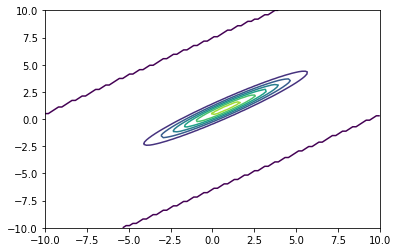

In [21]:
D = 2
Lmin = 0.1
Lmax = 10
A = random_covariance(D,Lmin,Lmax)

amin = -10
amax = 10
a = torch.linspace(amin,amax,100)
x,y = torch.meshgrid(a,a)

target_dist = torch.distributions.MultivariateNormal(torch.rand([D]),A)
z = torch.zeros((100,100))
for i,ai in enumerate(a):
    for j,aj in enumerate(a):
        z[i,j] = torch.exp(target_dist.log_prob(torch.Tensor([ai,aj])))
plt.contour(x,y,z)

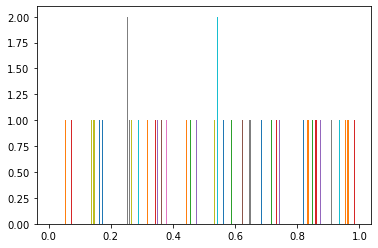

In [28]:
D = 2
Lmin = 0
Lmax = 1
values = []
for i in range(1000):
    sigma = random_covariance(D,Lmin,Lmax)
    _,S,_ = torch.svd(sigma)
    values.append(S)
_,_,_ = plt.hist(values)

In [55]:
D = 100
epsilon = 1e3
Lmin = 0.1
Lmax = 10
L = torch.eye(D) * torch.distributions.Uniform(Lmin,Lmax).sample([D])
#generate a random unitary matrix (use QR decomposition to obtain)
Q,_ = torch.qr(torch.rand([D,D]))
Q,_ = torch.qr(torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D)).sample([D]))
#obtain the desired covariance by multiplication:
sigma = torch.mm(torch.mm(Q,L),Q.T)
sigma = torch.round(sigma*epsilon)/epsilon

In [ ]:
print(torch.max(sigma))
print(torch.min(sigma))

In [ ]:
a,b,c=plt.hist((sigma.numpy()).flatten(),bins=D)

In [421]:
U,S,V = torch.svd(sigma)

gpf testing

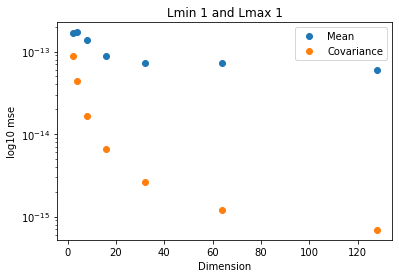

In [80]:
#full rank gaussians
Ds = 2**np.arange(1,8,1)
num_runs = 10
Lmin = 1
Lmax = 1

dec = 2

mean_mse = torch.zeros((len(Ds),num_runs))
cov_mse = torch.zeros((len(Ds),num_runs))
for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+1
    for j in range(num_runs):
        m = my.custom_round(standard_normal.sample(),dec)
        S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
        p = torch.distributions.MultivariateNormal(m,S)
        x0 = standard_normal.sample([N])
        x = gpf(x0,p)
        mean_mse[i,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
        cov_mse[i,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
        
        
plt.semilogy(Ds,torch.mean(mean_mse,1),'o',label = 'Mean')
plt.semilogy(Ds,torch.mean(cov_mse,1),'o',label = 'Covariance')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('log10 mse')
plt.title('Lmin {} and Lmax {}'.format(Lmin,Lmax))
plt.show()

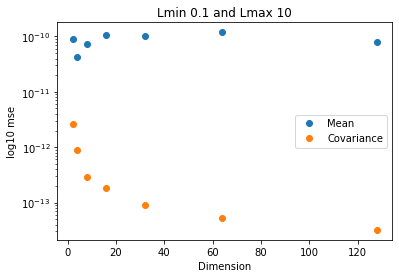

In [81]:
Lmin = 0.1
Lmax = 10

mean_mse = torch.zeros((len(Ds),num_runs))
cov_mse = torch.zeros((len(Ds),num_runs))
for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+1
    for j in range(num_runs):
        m = my.custom_round(standard_normal.sample(),dec)
        S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
        p = torch.distributions.MultivariateNormal(m,S)
        x0 = standard_normal.sample([N])
        x = gpf(x0,p)
        mean_mse[i,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
        cov_mse[i,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
        
        
plt.semilogy(Ds,torch.mean(mean_mse,1),'o',label = 'Mean')
plt.semilogy(Ds,torch.mean(cov_mse,1),'o',label = 'Covariance')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('log10 mse')
plt.title('Lmin {} and Lmax {}'.format(Lmin,Lmax))
plt.show()

linear svgd testing

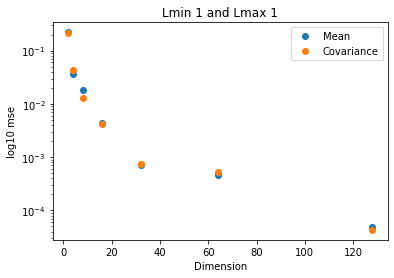

In [82]:
Ds = 2**np.arange(1,8,1)
num_runs = 10
Lmin = 1
Lmax = 1

dec = 2

mean_mse = torch.zeros((len(Ds),num_runs))
cov_mse = torch.zeros((len(Ds),num_runs))
for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+1
    for j in range(num_runs):
        m = my.custom_round(standard_normal.sample(),dec)
        S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
        p = torch.distributions.MultivariateNormal(m,S)
        x0 = standard_normal.sample([N])
        x = svgd(x0,p,kernel = 'linear')
        mean_mse[i,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
        cov_mse[i,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
        
        
plt.semilogy(Ds,torch.mean(mean_mse,1),'o',label = 'Mean')
plt.semilogy(Ds,torch.mean(cov_mse,1),'o',label = 'Covariance')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('log10 mse')
plt.title('Lmin {} and Lmax {}'.format(Lmin,Lmax))
plt.show()

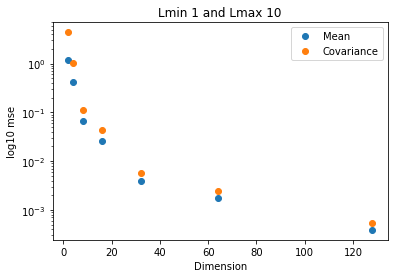

In [4]:
Ds = 2**np.arange(1,8,1)
num_runs = 10
Lmin = 1
Lmax = 10

dec = 2

num_iter = 50000
eta = 1e-4

mean_mse = torch.zeros((len(Ds),num_runs))
cov_mse = torch.zeros((len(Ds),num_runs))
for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+1
    for j in range(num_runs):
        m = my.custom_round(standard_normal.sample(),dec)
        S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
        p = torch.distributions.MultivariateNormal(m,S)
        x0 = standard_normal.sample([N])
        x = my.svgd(x0,p,kernel = 'linear',eta = eta,num_iter = num_iter)
        mean_mse[i,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
        cov_mse[i,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
        
        
plt.semilogy(Ds,torch.mean(mean_mse,1),'o',label = 'Mean')
plt.semilogy(Ds,torch.mean(cov_mse,1),'o',label = 'Covariance')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('log10 mse')
plt.title('Lmin {} and Lmax {}'.format(Lmin,Lmax))
plt.show()

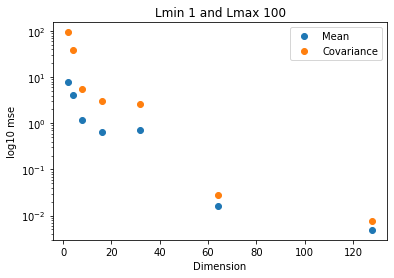

In [33]:
Ds = 2**np.arange(1,8,1)
num_runs = 1
Lmin = 1
Lmax = 100

num_iter = 50000
eta = 1e-3

dec = 4

hist = []
ps = []

mean_mse = torch.zeros((len(Ds),num_runs))
cov_mse = torch.zeros((len(Ds),num_runs))
for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+1
    for j in range(num_runs):
        m = my.custom_round(standard_normal.sample(),dec)
        S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
        p = torch.distributions.MultivariateNormal(m,S)
        x0 = standard_normal.sample([N])
        x = svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter, history = True)
        hist.append(x)
        ps.append(p)
        mean_mse[i,j] = torch.mean((torch.mean(x[-1],0)-p.mean)**2)
        cov_mse[i,j] = torch.mean((my.estimate_cov(x[-1]) - p.covariance_matrix)**2)
        
        
plt.semilogy(Ds,torch.mean(mean_mse,1),'o',label = 'Mean')
plt.semilogy(Ds,torch.mean(cov_mse,1),'o',label = 'Covariance')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('log10 mse')
plt.title('Lmin {} and Lmax {}'.format(Lmin,Lmax))
plt.show()

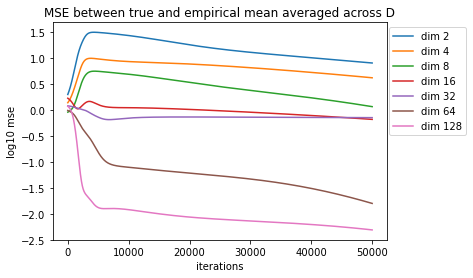

In [34]:
for i,x in enumerate(hist):
    mse = torch.mean(torch.square(torch.mean(x,1) - ps[i].mean),1)
    plt.plot(torch.log10(mse),label='dim {}'.format(Ds[i]))
plt.title('MSE between true and empirical mean averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()

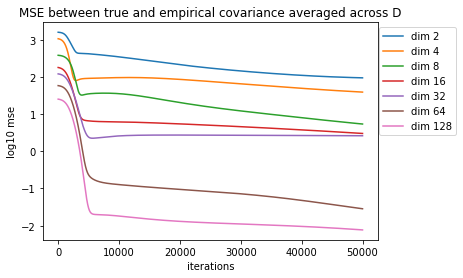

In [35]:
for i,x in enumerate(hist):
    mse = [torch.mean(torch.square(my.estimate_cov(xt) - ps[i].covariance_matrix)) for xt in x]
    plt.plot(torch.log10(torch.FloatTensor(mse)),label='dim {}'.format(Ds[i]))
plt.title('MSE between true and empirical covariance averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()

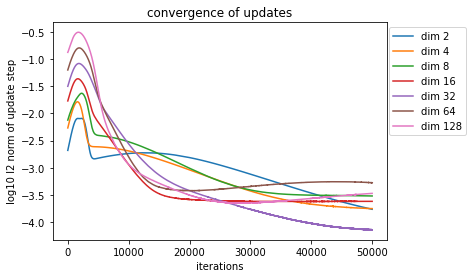

In [36]:
for i,x in enumerate(hist):
    l2step = torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
    plt.plot(torch.log10(l2step),label='dim {}'.format(Ds[i]))
plt.title('convergence of updates')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 l2 norm of update step')
plt.xlabel('iterations')
plt.show()

In [54]:
Lmin = 1
Lmax = 100

num_iter = 500000
eta = 1e-3

dec = 4


D = 2

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
N = D+1
    
m = my.custom_round(standard_normal.sample(),dec)
S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
p = torch.distributions.MultivariateNormal(m,S)
x0 = standard_normal.sample([N])
x_hist = svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter,history = True)


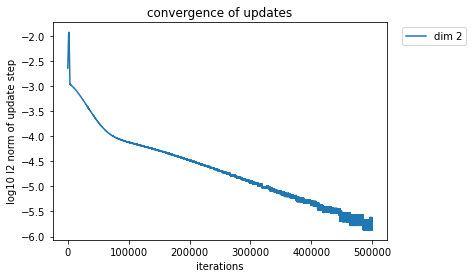

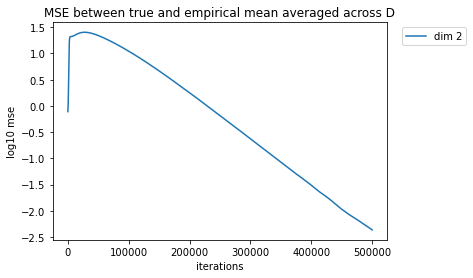

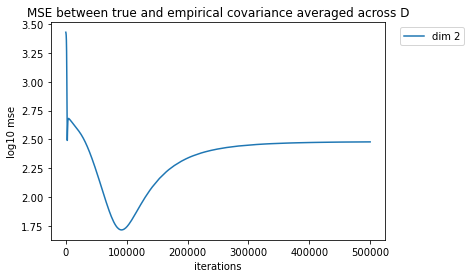

In [55]:
l2step = torch.linalg.norm(x_hist[1:]-x_hist[:-1],dim=(1,2))
plt.plot(torch.log10(l2step),label='dim {}'.format(D))
plt.title('convergence of updates')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 l2 norm of update step')
plt.xlabel('iterations')
plt.show()
mse_mean = torch.mean(torch.square(torch.mean(x_hist,1) - p.mean),1)
plt.plot(torch.log10(mse_mean),label='dim {}'.format(D))
plt.title('MSE between true and empirical mean averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()
mse_cov = [torch.mean(torch.square(my.estimate_cov(xt) - p.covariance_matrix)) for xt in x_hist]
plt.plot(torch.log10(torch.FloatTensor(mse_cov)),label='dim {}'.format(D))
plt.title('MSE between true and empirical covariance averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()


In [56]:
print(my.estimate_cov(x_hist[-1]))
print(p.covariance_matrix)
print(torch.mean(x_hist[-1],0))
print(p.mean)

tensor([[119.1925, -21.3173],
        [-21.3173,  64.8960]])
tensor([[ 89.4773, -16.0175],
        [-16.0175,  48.6823]])
tensor([ 1.2626, -0.4125])
tensor([ 1.1751, -0.3808])


In [57]:
x_gpf = gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter,history = True)

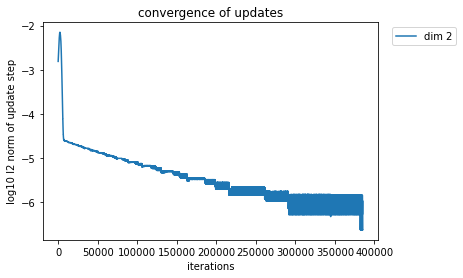

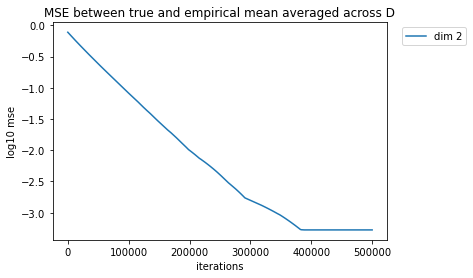

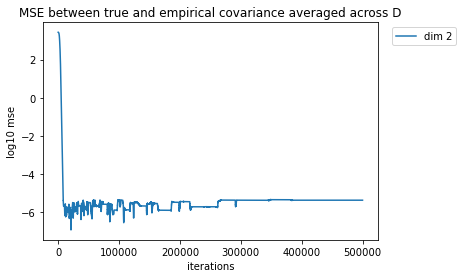

In [58]:
l2step = torch.linalg.norm(x_gpf[1:]-x_gpf[:-1],dim=(1,2))
plt.plot(torch.log10(l2step),label='dim {}'.format(D))
plt.title('convergence of updates')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 l2 norm of update step')
plt.xlabel('iterations')
plt.show()
mse_mean = torch.mean(torch.square(torch.mean(x_gpf,1) - p.mean),1)
plt.plot(torch.log10(mse_mean),label='dim {}'.format(D))
plt.title('MSE between true and empirical mean averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()
mse_cov = [torch.mean(torch.square(my.estimate_cov(xt) - p.covariance_matrix)) for xt in x_gpf]
plt.plot(torch.log10(torch.FloatTensor(mse_cov)),label='dim {}'.format(D))
plt.title('MSE between true and empirical covariance averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()


In [59]:
print(my.estimate_cov(x_gpf[-1]))
print(p.covariance_matrix)
print(torch.mean(x_gpf[-1],0))
print(p.mean)

tensor([[ 89.4742, -16.0183],
        [-16.0183,  48.6847]])
tensor([[ 89.4773, -16.0175],
        [-16.0175,  48.6823]])
tensor([ 1.1487, -0.3617])
tensor([ 1.1751, -0.3808])


In [60]:
Lmin = 1
Lmax = 10

num_iter = 500000
eta = 1e-3

dec = 4


D = 2

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
N = D+1
    
m = my.custom_round(standard_normal.sample(),dec)
S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
p = torch.distributions.MultivariateNormal(m,S)
x0 = standard_normal.sample([N])

x_lin = svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter,history = True)
x_gpf = gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter,history = True)



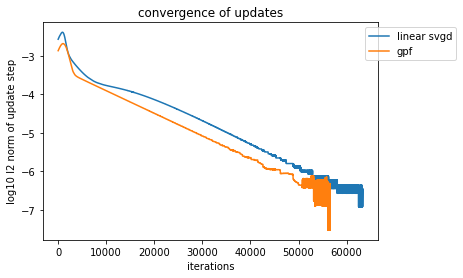

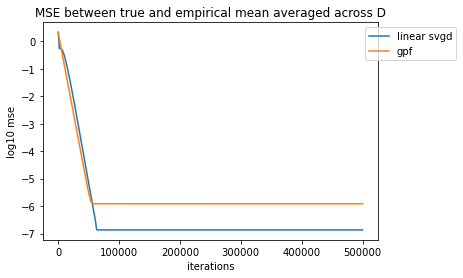

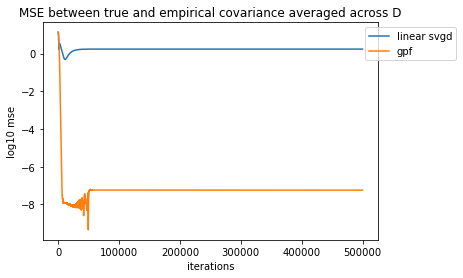

In [69]:
names = ['linear svgd','gpf']
hist = [x_lin,x_gpf]
for i,x in enumerate(hist):
    l2step = torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
    plt.plot(torch.log10(l2step),label='{}'.format(names[i]))
plt.title('convergence of updates')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 l2 norm of update step')
plt.xlabel('iterations')
plt.show()
for i,x in enumerate(hist):
    mse_mean = torch.mean(torch.square(torch.mean(x,1) - p.mean),1)
    plt.plot(torch.log10(mse_mean),label='{}'.format(names[i]))
plt.title('MSE between true and empirical mean averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()
for i,x in enumerate(hist):
    mse_cov = [torch.mean(torch.square(my.estimate_cov(xt) - p.covariance_matrix)) for xt in x]
    plt.plot(torch.log10(torch.FloatTensor(mse_cov)),label='{}'.format(names[i]))
plt.title('MSE between true and empirical covariance averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()


In [72]:
print('true mean:\n {}'.format(p.mean))
for i,x in enumerate(hist):
    print('empirical mean {}:\n {}'.format(names[i],torch.mean(x[-1],0)))
print('true cov: {}'.format(p.covariance_matrix))
for i,x in enumerate(hist):
    print('empirical cov {}:\n {}'.format(names[i],my.estimate_cov(x[-1])))

true mean:
 tensor([-0.7305, -1.9297])
empirical mean linear svgd:
 tensor([-0.7308, -1.9301])
empirical mean gpf:
 tensor([-0.7295, -1.9285])
true cov: tensor([[4.9730, 2.3302],
        [2.3302, 5.1346]])
empirical cov linear svgd:
 tensor([[6.6303, 3.1065],
        [3.1065, 6.8454]])
empirical cov gpf:
 tensor([[4.9729, 2.3300],
        [2.3300, 5.1342]])


In [4]:
Lmin = 1
Lmax = 10

num_iter = 100000
eta = 1e-3

dec = 4


D = 32

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
N = D+2
    
m = my.custom_round(standard_normal.sample(),dec)
S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
p = torch.distributions.MultivariateNormal(m,S)
x0 = standard_normal.sample([N])

x_lin = svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter,history = True)
x_lin = x_lin[::100]
x_gpf = gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter,history = True)
x_gpf = x_gpf[::100]


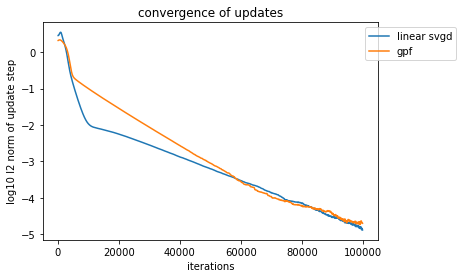

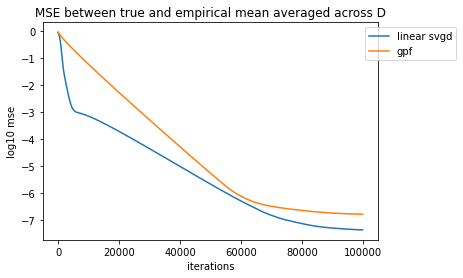

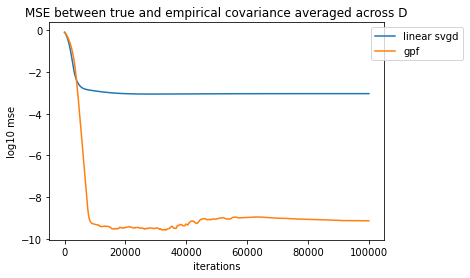

In [12]:
names = ['linear svgd','gpf']
hist = [x_lin,x_gpf]
for i,x in enumerate(hist):
    l2step = torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
    plt.plot(np.arange(100,num_iter,100),torch.log10(l2step),label='{}'.format(names[i]))
plt.title('convergence of updates')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 l2 norm of update step')
plt.xlabel('iterations')
plt.show()
for i,x in enumerate(hist):
    mse_mean = torch.mean(torch.square(torch.mean(x,1) - p.mean),1)
    plt.plot(np.arange(0,num_iter,100),torch.log10(mse_mean),label='{}'.format(names[i]))
plt.title('MSE between true and empirical mean averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()
for i,x in enumerate(hist):
    mse_cov = [torch.mean(torch.square(my.estimate_cov(xt) - p.covariance_matrix)) for xt in x]
    plt.plot(np.arange(0,num_iter,100),torch.log10(torch.FloatTensor(mse_cov)),label='{}'.format(names[i]))
plt.title('MSE between true and empirical covariance averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()


In [13]:
Lmin = 1
Lmax = 100

num_iter = 100000
eta = 1e-3

dec = 4


D = 32

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
N = D+2
    
m = my.custom_round(standard_normal.sample(),dec)
S = my.custom_round(my.random_covariance(D,Lmin,Lmax),dec)
p = torch.distributions.MultivariateNormal(m,S)
x0 = standard_normal.sample([N])

x_lin = svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter,history = True)
x_lin = x_lin[::100]
x_gpf = gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter,history = True)
x_gpf = x_gpf[::100]


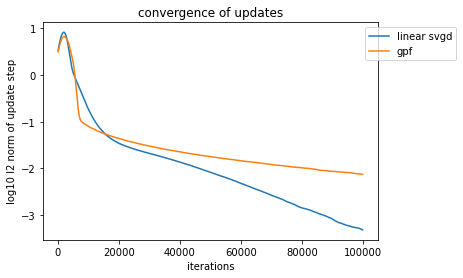

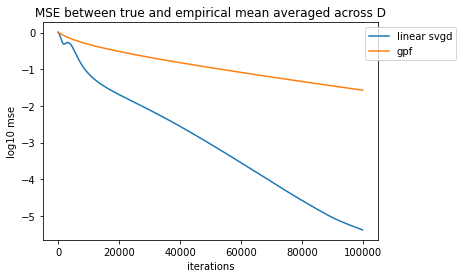

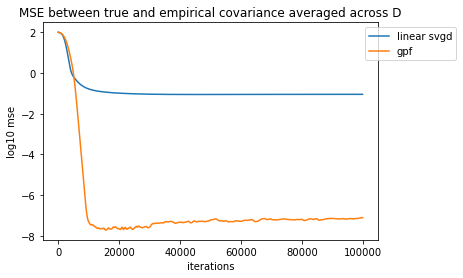

In [15]:
names = ['linear svgd','gpf']
hist = [x_lin,x_gpf]
for i,x in enumerate(hist):
    l2step = torch.linalg.norm(x[1:]-x[:-1],dim=(1,2))
    plt.plot(np.arange(100,num_iter,100),torch.log10(l2step),label='{}'.format(names[i]))
plt.title('convergence of updates')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 l2 norm of update step')
plt.xlabel('iterations')
plt.show()
for i,x in enumerate(hist):
    mse_mean = torch.mean(torch.square(torch.mean(x,1) - p.mean),1)
    plt.plot(np.arange(0,num_iter,100),torch.log10(mse_mean),label='{}'.format(names[i]))
plt.title('MSE between true and empirical mean averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()
for i,x in enumerate(hist):
    mse_cov = [torch.mean(torch.square(my.estimate_cov(xt) - p.covariance_matrix)) for xt in x]
    plt.plot(np.arange(0,num_iter,100),torch.log10(torch.FloatTensor(mse_cov)),label='{}'.format(names[i]))
plt.title('MSE between true and empirical covariance averaged across D')
plt.legend(loc = 'upper right',bbox_to_anchor=[1.25,1.])
plt.ylabel('log10 mse')
plt.xlabel('iterations')
plt.show()


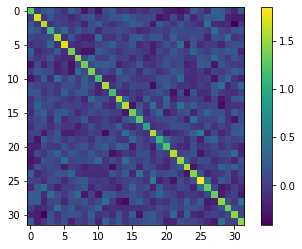

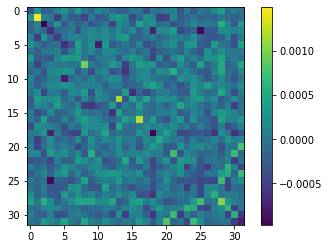

In [18]:
plt.imshow(my.estimate_cov(x_lin[-1]) - p.covariance_matrix)
plt.colorbar()
plt.show()
plt.imshow(my.estimate_cov(x_gpf[-1]) - p.covariance_matrix)
plt.colorbar()
plt.show()

In [39]:
D = 100
C = [1,10]
Ns = np.arange(11,171,20)

dec = 4 #decimals to round the target to

standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
m = my.custom_round(standard_normal.sample(),dec)
S = my.custom_round(my.random_covariance(D,C[0],C[1]),dec)
p = torch.distributions.MultivariateNormal(m,S)

num_iter = 50000
eta = 1e-3

mean_lin = torch.zeros((len(Ns),))
cov_lin = torch.zeros((len(Ns),))
mean_gpf = torch.zeros((len(Ns),))
cov_gpf = torch.zeros((len(Ns),))

for i,N in enumerate(Ns):
    x0 = standard_normal.sample([N])
    
    x = my.svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter)
    mean_lin[i] = torch.mean((torch.mean(x,0)-p.mean)**2)
    cov_lin[i] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
    
    x = my.gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter)
    mean_gpf[i] = torch.mean((torch.mean(x,0)-p.mean)**2)
    cov_gpf[i] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)

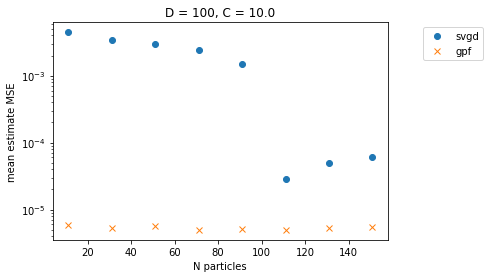

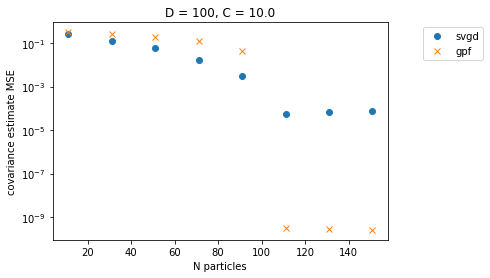

In [47]:
plt.semilogy(Ns,mean_lin,'o',label= 'svgd')
plt.semilogy(Ns,mean_gpf,'x',label = 'gpf')
plt.title('D = {}, C = {}'.format(D,C[1]/C[0]))
plt.xlabel('N particles')
plt.ylabel('mean estimate MSE')
plt.legend(bbox_to_anchor=[1.3,1.])
plt.show()
plt.semilogy(Ns,cov_lin,'o',label= 'svgd')
plt.semilogy(Ns,cov_gpf,'x',label = 'gpf')
plt.title('D = {}, C = {}'.format(D,C[1]/C[0]))
plt.xlabel('N particles')
plt.ylabel('covariance estimate MSE')
plt.legend(bbox_to_anchor=[1.3,1.])
plt.show()

In [48]:
Ns

array([ 11,  31,  51,  71,  91, 111, 131, 151])

In [57]:
N = 102
x0 = standard_normal.sample([N])
    
x_lin = my.svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter)

x_gpf = my.gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter)

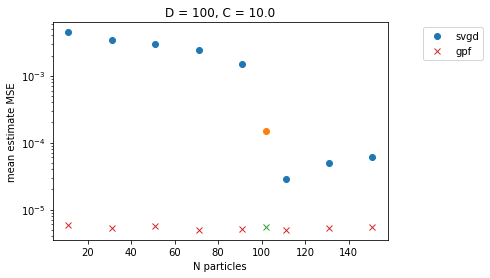

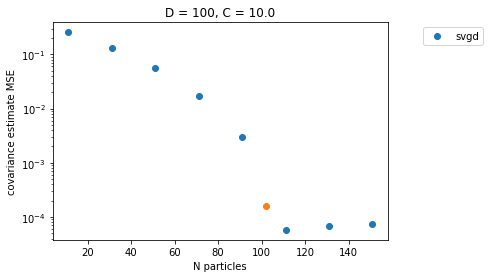

In [59]:
lin_mean = torch.mean(torch.square(torch.mean(x_lin,0)-p.mean))
gpf_mean = torch.mean(torch.square(torch.mean(x_gpf,0)-p.mean))
lin_cov = torch.mean(torch.square(my.estimate_cov(x_lin)-p.covariance_matrix))
gpf_cov = torch.mean(torch.square(my.estimate_cov(x_gpf)-p.covariance_matrix))

plt.semilogy(Ns,mean_lin,'o',label= 'svgd')
plt.semilogy(N,lin_mean,'o')
plt.semilogy(N,gpf_mean,'x')
plt.semilogy(Ns,mean_gpf,'x',label = 'gpf')
plt.title('D = {}, C = {}'.format(D,C[1]/C[0]))
plt.xlabel('N particles')
plt.ylabel('mean estimate MSE')
plt.legend(bbox_to_anchor=[1.3,1.])
plt.show()
plt.semilogy(Ns,cov_lin,'o',label= 'svgd')
#plt.semilogy(Ns,cov_gpf,'x',label = 'gpf')
plt.semilogy(N,lin_cov,'o')
#plt.semilogy(N,gpf_cov,'x')
plt.title('D = {}, C = {}'.format(D,C[1]/C[0]))
plt.xlabel('N particles')
plt.ylabel('covariance estimate MSE')
plt.legend(bbox_to_anchor=[1.3,1.])
plt.show()

linear svgd debug

In [389]:
it = 69
idx = 26

In [390]:
k_sequence = torch.zeros((it,2))
dk_sequence = torch.zeros((it,2))
x_sequence = torch.zeros((it,3))
for i in range(it):
    k,dk = linear_kernel(hist[idx][i],hist[idx][i].shape[0])
    k_sequence[i,0] = torch.min(k)
    k_sequence[i,1] = torch.max(k)
    dk_sequence[i,0] = torch.min(dk)
    dk_sequence[i,1] = torch.max(dk)
    x_sequence[i,0] = torch.max(hist[idx][i])
    x_sequence[i,1] = torch.min(hist[idx][i])
    x_sequence[i,2] = torch.min(abs(hist[idx][i]))

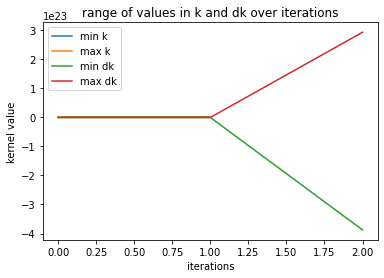

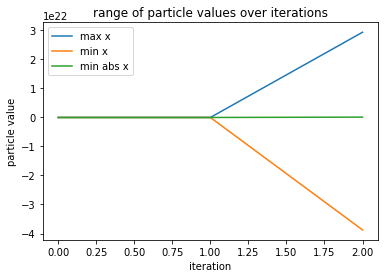

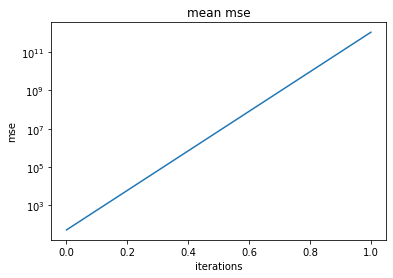

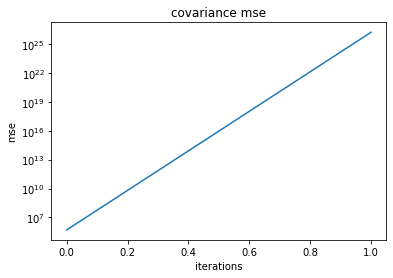

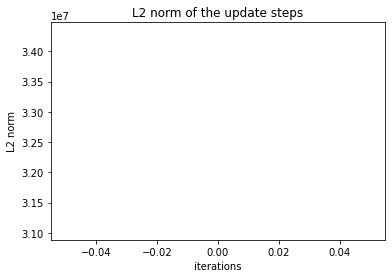

In [391]:
plt.plot(k_sequence)
plt.plot(dk_sequence)
plt.xlabel('iterations')
plt.ylabel('kernel value')
plt.legend(loc='upper left',labels=['min k','max k','min dk','max dk'])
plt.title('range of values in k and dk over iterations')
plt.show()
plt.plot(x_sequence)
plt.xlabel('iteration')
plt.ylabel('particle value')
plt.legend(loc='upper left',labels=['max x','min x','min abs x'])
plt.title('range of particle values over iterations')
plt.show()
plt.semilogy([torch.mean((ps[idx].mean - torch.mean(hist[idx][i],0))**2) for i in range(it)])
plt.xlabel('iterations')
plt.ylabel('mse')
plt.title('mean mse')
plt.show()
plt.semilogy([torch.mean((ps[idx].covariance_matrix - my.estimate_cov(hist[idx][i]))**2) for i in range(it)])
plt.xlabel('iterations')
plt.ylabel('mse')
plt.title('covariance mse')
plt.show()
diff_norm = torch.linalg.norm(hist[idx][1:]-hist[idx][:-1],dim=(1,2))
plt.plot(diff_norm)
plt.title('L2 norm of the update steps')
plt.xlabel('iterations')
plt.ylabel('L2 norm')
plt.show()

In [404]:
print(torch.mean(x,0))
print(p.mean)

tensor([  248268.9219,  1833745.1250,  -370352.3750,  -371158.2500,
         1197344.2500,  -563288.3750, -1376940.2500, -1177156.1250])
tensor([ 0.2860, -0.8685, -0.2783, -1.1261,  0.5373,  2.0711,  0.1224,  0.4960])


In [403]:
t = 1
p = ps[idx]
x = hist[idx][t]


In [393]:
def grad_est(x,p):
    x.requires_grad = True
    logpx = p.log_prob(x)
    logpx.sum().backward()
    return x.grad

In [396]:
grad_est(x,p)

tensor([[ 9.8653e+06,  7.1087e+07, -1.5009e+07, -1.4514e+07,  4.6470e+07,
         -2.1588e+07, -5.3404e+07, -4.5678e+07],
        [-1.0480e+08, -7.5904e+08,  1.5900e+08,  1.5505e+08, -4.9640e+08,
          2.3070e+08,  5.7045e+08,  4.8781e+08],
        [-6.2714e+07, -4.5700e+08,  9.4823e+07,  9.3410e+07, -2.9903e+08,
          1.3904e+08,  3.4361e+08,  2.9375e+08],
        [ 3.4015e+08,  2.4755e+09, -5.1467e+08, -5.0594e+08,  1.6196e+09,
         -7.5303e+08, -1.8611e+09, -1.5912e+09],
        [-1.6914e+08, -1.2439e+09,  2.5443e+08,  2.5447e+08, -8.1452e+08,
          3.7902e+08,  9.3585e+08,  7.9973e+08],
        [-4.4757e+08, -3.2663e+09,  6.7617e+08,  6.6772e+08, -2.1375e+09,
          9.9401e+08,  2.4561e+09,  2.0996e+09],
        [-1.6332e+08, -1.1906e+09,  2.4687e+08,  2.4338e+08, -7.7910e+08,
          3.6229e+08,  8.9525e+08,  7.6533e+08],
        [ 1.5498e+08,  1.1365e+09, -2.3349e+08, -2.3245e+08,  7.4405e+08,
         -3.4615e+08, -8.5492e+08, -7.3066e+08],
        [-8.0341

In [395]:
my.animate_trajectory(hist[idx],ps[idx],-10,10)

AssertionError: can only animate 2D trajectories

In [ ]:
torch.inverse(k)@(-dk)

rbf svgd

In [ ]:
Ds = np.arange(5,105,10)
num_runs = 1
mean_mse = torch.zeros((len(Ds),num_runs))
cov_mse = torch.zeros((len(Ds),num_runs))

Lmin = 1
Lmax = 100

for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+1
    for j in range(num_runs):
        p = torch.distributions.MultivariateNormal(standard_normal.sample(),my.random_covariance(D,Lmin,Lmax))
        x0 = standard_normal.sample([N])
        x = my.svgd(x0,p,'rbf')
        mean_mse[i,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
        cov_mse[i,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
        
        
plt.semilogy(Ds,torch.mean(mean_mse,1),'o',label = 'Mean')
plt.semilogy(Ds,torch.mean(cov_mse,1),'o',label = 'Covariance')
plt.legend()
plt.xlabel('Dimension')
plt.ylabel('log10 mse')
plt.title('mse for full rank gaussians')
plt.show()